# K-means algorithm 
### for PTV margin classification in radiosurgery for multiple mets

The following script details the k-means clustering in three classes for PTV margin (0.5, 1 or 2 mm) taken into account geometric, dosimetric and setup uncertainties information.

K-means was developed for three classes, however, the elbow curve defined as 5 classes the optimal for this dataset.

The complete dataset can be provided for scientists with a notification to authors.


In [2]:
from platform import python_version

# Part of the PhD project based on artificial intelligence on radiosurgery for multiple mets
# The information extracted from this notebook has to be notified to authors. 

__author__ = "José Alejandro Rojas López"
__institution__ = "Universidad Nacional de Córdoba"
__copyright__ = "Copyright (C) 2022 Alejandro Rojas"
__license__ = "Public Domain"
__version__ = "1.0"
__email__ = "alexrojas@ciencias.unam.mx"

print(python_version())

3.9.5


In [4]:
import pandas as pd
import xlrd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [5]:
book = xlrd.open_workbook('DatasetAll.xls')
sheet = book.sheet_by_name('Sheet1')
data = [[sheet.cell_value(r, c) for c in range(sheet.ncols)] for r in range(sheet.nrows)]

In [6]:
num = data[0]
vol = data[1]
d2iso = data[2]
margen = data[3]

for i in range(len(margen)):
    if margen[i] == 0.5:
        margen[i] = 0


In [7]:
datos = pd.DataFrame({'num': num, 'd2iso': d2iso, 'vol': vol, 'margen': margen})
datos.head(5)


,num,d2iso,vol,margen
0,5.0,41.0,1.047,2.0
1,5.0,41.0,2.086,1.0
2,5.0,60.0,0.142,1.0
3,5.0,72.0,0.172,1.0
4,5.0,33.0,0.096,1.0


/var/folders/gw/xyk99n6d2cjdnqq_ttpgj92h0000gp/T/ipykernel_15802/2750335006.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


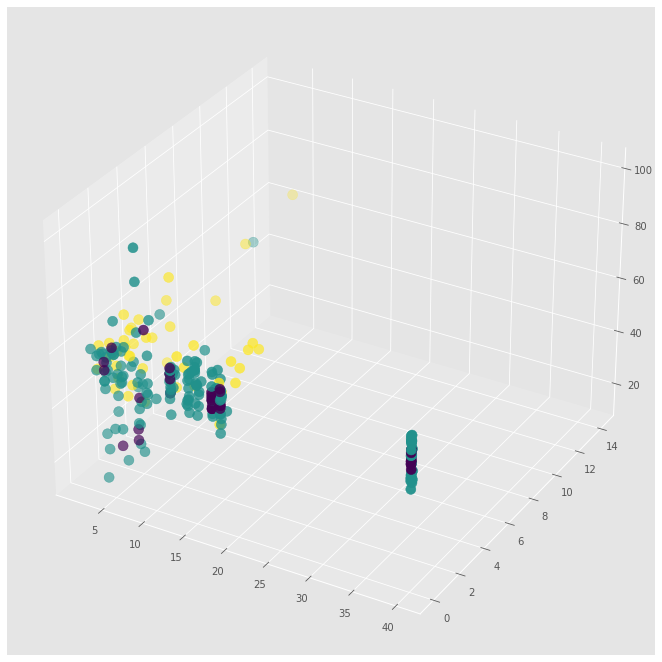

In [11]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(num, vol, d2iso, c=margen,s=100)

In [12]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
11,vol,margen,0.444042,0.444042
14,margen,vol,0.444042,0.444042
3,num,margen,-0.312248,0.312248
12,margen,num,-0.312248,0.312248
2,num,vol,-0.269720,0.269720
8,vol,num,-0.269720,0.269720
1,num,d2iso,0.133011,0.133011
4,d2iso,num,0.133011,0.133011
6,d2iso,vol,0.057974,0.057974
9,vol,d2iso,0.057974,0.057974


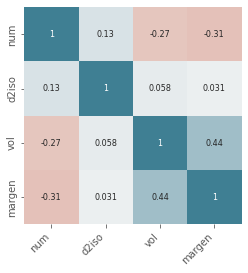

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

IndexError: index 3 is out of bounds for axis 0 with size 3

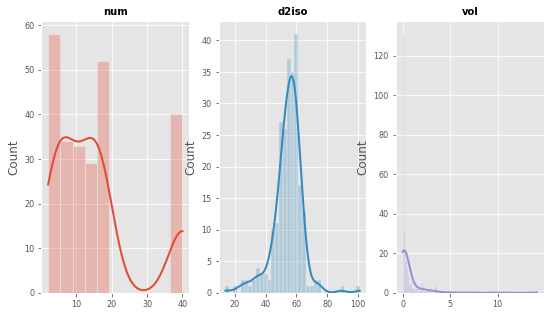

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [16]:
# División de los datos en train y test
# ==============================================================================
X = datos[['vol', 'd2iso']]
y = datos['num']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [17]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     11.66
Date:                Mon, 16 May 2022   Prob (F-statistic):           1.66e-05
Time:                        13:34:53   Log-Likelihood:                -754.40
No. Observations:                 196   AIC:                             1515.
Df Residuals:                     193   BIC:                             1525.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8140      4.853      0.992      0.3

In [18]:
# Correlación lineal entre las dos variables
# ==============================================================================
corr_test = pearsonr(x = datos['vol'], y =  datos['d2iso'])
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  0.05797372775869206
P-value:  0.365246642838198


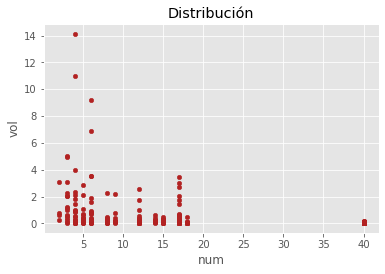

In [19]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))

datos.plot(
    x    = 'num',
    y    = 'vol',
    c    = 'firebrick',
    kind = "scatter",
    ax   = ax
)
ax.set_title('Distribución');

## Kmeans

In [23]:
print(datos.groupby('margen').size())

margen
0.0     37
1.0    162
2.0     47
dtype: int64


/Users/alejandro/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


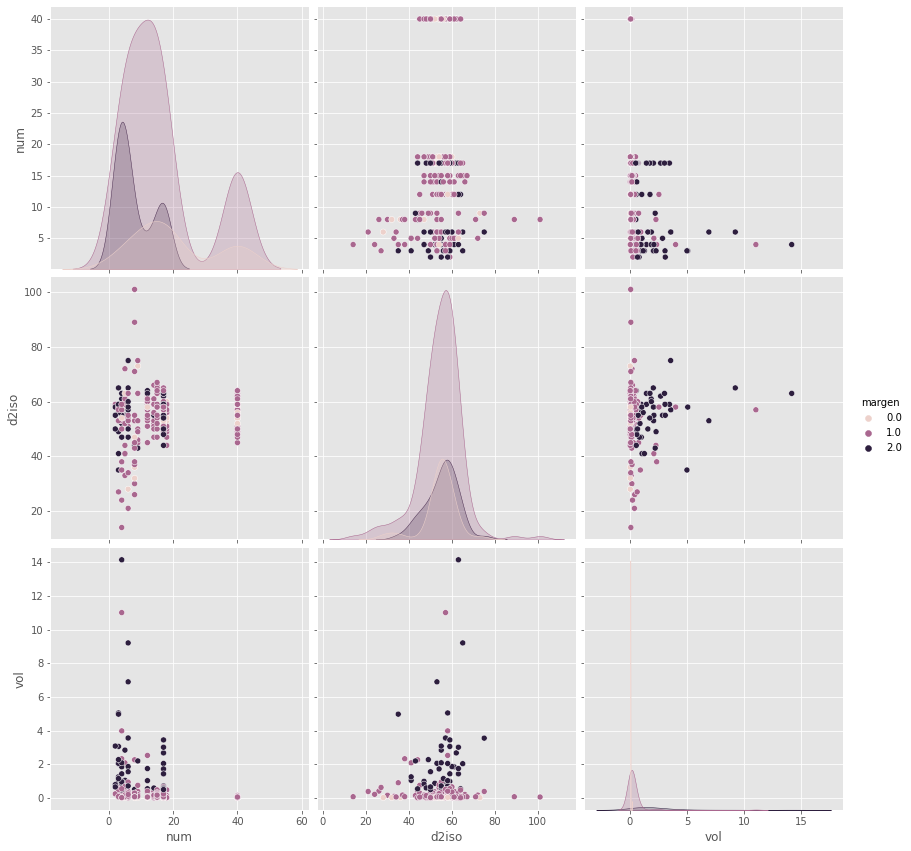

In [24]:
sb.pairplot(datos.dropna(), hue='margen',size=4,vars=["num","d2iso","vol"],kind='scatter')

In [25]:
X = np.array(datos[["num","d2iso","vol"]])
y = np.array(datos['margen'])
X.shape

(246, 3)

In [26]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

In [27]:
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[6.91428571e+00 3.81428571e+01 7.57457143e-01]
 [1.11695906e+01 5.74795322e+01 7.58912281e-01]
 [4.00000000e+01 5.59250000e+01 5.04500000e-02]]


In [28]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

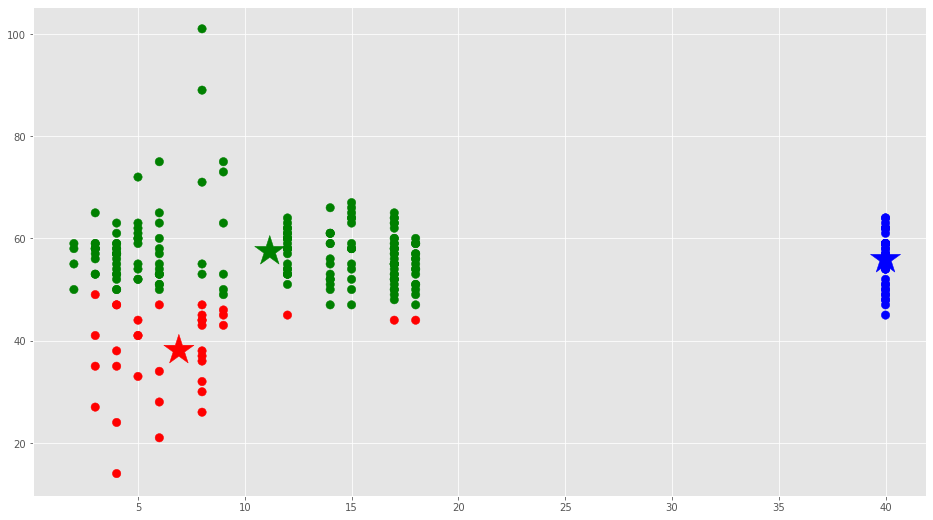

In [29]:
# Getting the values and plotting it
f1 = datos['num'].values
f2 = datos['d2iso'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

/var/folders/gw/xyk99n6d2cjdnqq_ttpgj92h0000gp/T/ipykernel_15802/2415819980.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


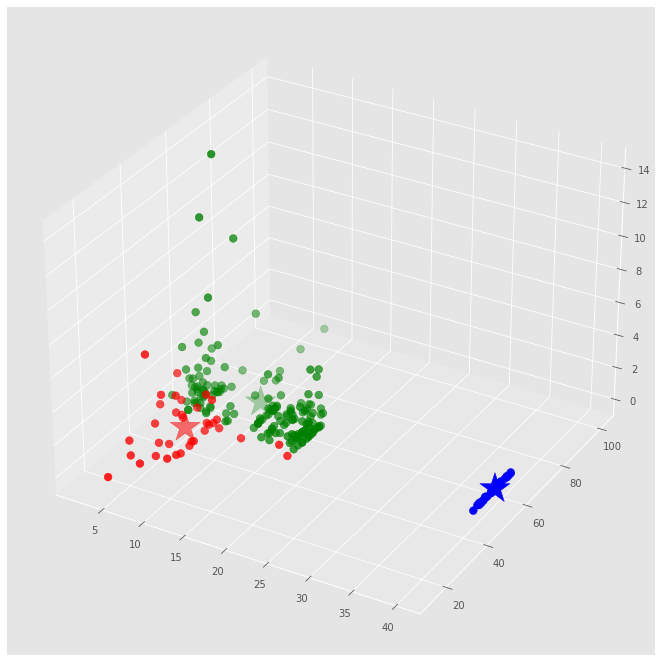

In [30]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [31]:
copy =  pd.DataFrame()
copy['d2iso']=datos['d2iso'].values
copy['margen']=datos['margen'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,35
1,green,171
2,blue,40


In [32]:
group_referrer_index = copy['label'] ==0
group_referrals = copy[group_referrer_index]

diversidadGrupo =  pd.DataFrame()
diversidadGrupo['margen']=[0.5,1,2]
diversidadGrupo['cantidad']=group_referrals.groupby('margen').size()
diversidadGrupo

,margen,cantidad
0,0.5,4
1,1.0,22
2,2.0,9


In [33]:
#vemos el representante del grupo, el usuario cercano a su centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
closest

array([ 49, 242, 220])

In [34]:
users=datos['num'].values
for row in closest:
    print(users[row])

8.0
12.0
40.0


In [35]:
X_new = np.array([[45.92,57.74,15.66]]) #nuevo dato

new_labels = kmeans.predict(X_new)
print(new_labels)

[2]


### PCA 

In [40]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [41]:
df = pd.DataFrame({'num': num, 'd2iso': d2iso, 'vol': vol, 'target':margen})

features = ['num','d2iso','vol']

# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

In [42]:
df.head(1)

,num,d2iso,vol,target
0,5.0,41.0,1.047,2.0


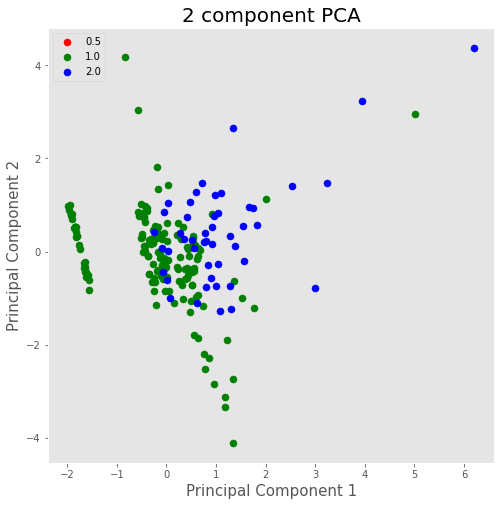

In [43]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0.5, 1.0, 2.0]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [44]:
pca.explained_variance_ratio_

array([0.42702465, 0.34844641])

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.42702465 0.34844641]


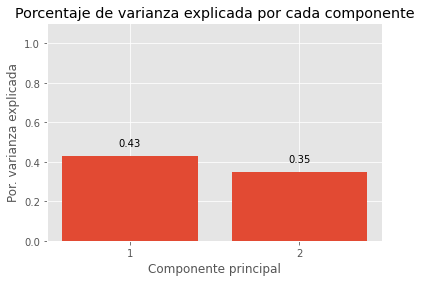

In [45]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(datos.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [46]:
print('-------------------------')
print('Varianza de cada variable')
print('-------------------------')
datos.var(axis=0)

-------------------------
Varianza de cada variable
-------------------------


num       144.156629
d2iso      90.176954
vol         2.408036
margen      0.341198
dtype: float64

In [47]:
import xgboost as xgb

In [48]:
# División de los datos en train y test
# ==============================================================================
X = datos[['vol', 'd2iso','num']]
y = datos['margen']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [49]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10,seed=123)
clf_xgb.fit(X_train, y_train)
preds_xgb = clf_xgb.predict(X_test)

[13:36:35] WARNING: /private/var/folders/gw/xyk99n6d2cjdnqq_ttpgj92h0000gp/T/pip-install-qm0w5ev2/xgboost_854662ce5dd44e4b8dd352f631338b91/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [50]:
accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]
print('Accuracy de XGBoost: ', accuracy_xgb)

Accuracy de XGBoost:  24.02


In [51]:
X=datos[['num', 'vol', 'd2iso']]  # Features
y=datos['margen'] 

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=600,max_depth=10,random_state=2,min_samples_leaf=1,min_samples_split=2,max_leaf_nodes=40,verbose=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8378378378378378


In [361]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=['num', 'vol', 'd2iso']).sort_values(ascending=False)
feature_imp

vol      0.592443
d2iso    0.243948
num      0.163609
dtype: float64

No handles with labels found to put in legend.


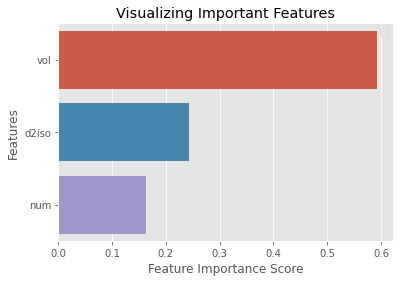

In [362]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()